# Ensemble stats - Difference in (weighted) mean - historical and rcp45/rcp85

- Weighted means take into account the number of days in each month

In [1]:
# import libraries
from datetime import datetime, timezone
import climag.plot_stats as cstats
import importlib
import xarray as xr
import matplotlib.pyplot as plt
import climag.plot_configs as cplt
import glob
import itertools
import os
import sys
import numpy as np
import geopandas as gpd

In [2]:
season_list = ["DJF", "MAM", "JJA", "SON"]
exp_list = ["historical", "rcp45", "rcp85"]
model_list = ["CNRM-CM5", "EC-EARTH", "HadGEM2-ES", "MPI-ESM-LR"]
dataset_list = ["EURO-CORDEX", "HiResIreland"]
stat_list = ["mean", "std", "max", "min"]

In [3]:
importlib.reload(cstats)

<module 'climag.plot_stats' from '/run/media/nms/Backup/Documents/Git/ClimAg/ClimAg/climag/plot_stats.py'>

In [4]:
def keep_minimal_vars(data):
    """
    Drop variables that are not needed
    """

    data = data.drop_vars(
        [
            "bm_gv",
            "bm_gr",
            "bm_dv",
            "bm_dr",
            "age_gv",
            "age_gr",
            "age_dv",
            "age_dr",
            "omd_gv",
            "omd_gr",
            "lai",
            "env",
            "wr",
            "aet",
            "sen_gv",
            "sen_gr",
            "abs_dv",
            "abs_dr",
            "c_bm",
            "bm",
            "pgro",
            "i_bm",
            "h_bm",
        ]
    )

    return data

In [5]:
def combine_datasets(dataset_dict, dataset_crs):
    dataset = xr.combine_by_coords(
        dataset_dict.values(), combine_attrs="override"
    )
    dataset.rio.write_crs(dataset_crs, inplace=True)

    return dataset

In [6]:
def generate_stats(dataset, stat, var):
    ds = {}

    for exp, model in itertools.product(exp_list, model_list):
        # auto-rechunking may cause NotImplementedError with object dtype
        # where it will not be able to estimate the size in bytes of object
        # data
        if model == "HadGEM2-ES":
            CHUNKS = 300
        else:
            CHUNKS = "auto"

        ds[f"{model}_{exp}"] = xr.open_mfdataset(
            glob.glob(
                os.path.join(
                    "data",
                    "ModVege",
                    dataset,
                    exp,
                    model,
                    f"*{dataset}*{model}*{exp}*.nc",
                )
            ),
            chunks=CHUNKS,
            decode_coords="all",
        )

        # copy CRS
        crs_ds = ds[f"{model}_{exp}"].rio.crs

        # remove spin-up year
        if exp == "historical":
            ds[f"{model}_{exp}"] = ds[f"{model}_{exp}"].sel(
                time=slice("1976", "2005")
            )
        else:
            ds[f"{model}_{exp}"] = ds[f"{model}_{exp}"].sel(
                time=slice("2041", "2070")
            )

        # convert HadGEM2-ES data back to 360-day calendar
        # this ensures that the correct weighting is applied when
        # calculating the weighted average
        if model == "HadGEM2-ES":
            ds[f"{model}_{exp}"] = ds[f"{model}_{exp}"].convert_calendar(
                "360_day", align_on="year"
            )

        # assign new coordinates and dimensions
        ds[f"{model}_{exp}"] = ds[f"{model}_{exp}"].assign_coords(exp=exp)
        ds[f"{model}_{exp}"] = ds[f"{model}_{exp}"].expand_dims(dim="exp")
        ds[f"{model}_{exp}"] = ds[f"{model}_{exp}"].assign_coords(model=model)
        ds[f"{model}_{exp}"] = ds[f"{model}_{exp}"].expand_dims(dim="model")

        if var == "prod":
            ds[f"{model}_{exp}"] = ds[f"{model}_{exp}"].assign(
                prod=ds[f"{model}_{exp}"]["i_bm"]
                + ds[f"{model}_{exp}"]["h_bm"]
            )
            ds[f"{model}_{exp}"] = (
                ds[f"{model}_{exp}"]
                .groupby("time.year")
                .max(dim="time", skipna=True)
            )
            ds[f"{model}_{exp}"] = ds[f"{model}_{exp}"].drop_vars(["gro"])

        # drop unnecessary variables
        ds[f"{model}_{exp}"] = keep_minimal_vars(data=ds[f"{model}_{exp}"])

        if stat == "mean" and var == "gro":
            # weighted mean
            weights = (
                ds[f"{model}_{exp}"]["time"].dt.days_in_month.groupby(
                    "time.season"
                )
                / ds[f"{model}_{exp}"]["time"]
                .dt.days_in_month.groupby("time.season")
                .sum()
            )

            # test that the sum of weights for each season is one
            np.testing.assert_allclose(
                weights.groupby("time.season").sum().values,
                np.ones(len(set(weights["season"].values))),
            )

            # calculate the weighted average
            ds[f"{model}_{exp}"] = (
                (ds[f"{model}_{exp}"] * weights)
                .groupby("time.season")
                .sum(dim="time")
            )

    # combine data
    ds = combine_datasets(ds, crs_ds)

    # ensemble stats
    if var == "gro":
        if stat == "mean":
            ds = ds.mean(dim="model", skipna=True)
        elif stat == "std":
            ds = ds.groupby("time.season").std(dim=["time", "model"], ddof=1)
        elif stat == "var":
            ds = ds.groupby("time.season").var(dim=["time", "model"], ddof=1)
        elif stat == "max":
            ds = ds.groupby("time.season").max(
                dim=["time", "model"], skipna=True
            )
        elif stat == "min":
            ds = ds.groupby("time.season").min(
                dim=["time", "model"], skipna=True
            )
    else:
        if stat == "mean":
            ds = ds.mean(dim=["year", "model"], skipna=True)
        elif stat == "std":
            ds = ds.std(dim=["year", "model"], ddof=1)
        elif stat == "var":
            ds = ds.var(dim=["year", "model"], ddof=1)
        elif stat == "max":
            ds = ds.max(dim=["year", "model"], skipna=True)
        elif stat == "min":
            ds = ds.min(dim=["year", "model"], skipna=True)

    # sort seasons in the correct order
    ds = ds.reindex(season=season_list)

    return ds

In [8]:
# mask out non-pasture areas
mask = gpd.read_file(
    os.path.join("data", "boundaries", "boundaries.gpkg"),
    layer="CLC_2018_MASK_PASTURE_2157_IE",
)

In [9]:
def plot_diff(data, var, levels):
    if var == "gro":
        fig = data[var].plot.contourf(
            x="rlon",
            y="rlat",
            col="season",
            row="exp",
            cmap="BrBG",
            extend="both",
            robust=True,
            levels=cstats.colorbar_levels(levels),
            subplot_kws={"projection": cplt.projection_hiresireland},
            transform=cplt.rotated_pole_transform(data),
            xlim=(-1.775, 1.6),
            ylim=(-2.1, 2.1),
            figsize=(12, 9.25),
            cbar_kwargs={
                "label": "Difference [kg DM ha⁻¹ day⁻¹]",
                "aspect": 30,
                "location": "bottom",
                "fraction": 0.085,
                "shrink": 0.85,
                "pad": 0.05,
                "extendfrac": "auto",
                "ticks": cstats.colorbar_ticks(levels),
            },
        )
    else:
        fig = data[var].plot.contourf(
            x="rlon",
            y="rlat",
            col="exp",
            cmap="BrBG",
            extend="both",
            robust=True,
            levels=cstats.colorbar_levels(levels),
            subplot_kws={"projection": cplt.projection_hiresireland},
            transform=cplt.rotated_pole_transform(data),
            xlim=(-1.775, 1.6),
            ylim=(-2.1, 2.1),
            figsize=(12, 4.75),
            cbar_kwargs={
                "label": "Difference [kg DM ha⁻¹ day⁻¹]",
                "aspect": 30,
                "location": "bottom",
                "fraction": 0.085,
                "shrink": 0.85,
                "pad": 0.05,
                "extendfrac": "auto",
                "ticks": cstats.colorbar_ticks(levels),
            },
        )
    for axis in fig.axs.flat:
        mask.to_crs(cplt.projection_hiresireland).plot(
            ax=axis, color="white", linewidth=0
        )
        cstats.ie_bbox.to_crs(cplt.projection_hiresireland).plot(
            ax=axis, edgecolor="darkslategrey", color="white", linewidth=0.5
        )
    fig.set_titles("{value}", weight="semibold", fontsize=14)
    plt.show()

In [10]:
def calculate_diff(data):
    data_out = xr.combine_by_coords(
        [
            (data.sel(exp="rcp45") - data.sel(exp="historical"))
            .assign_coords(exp="rcp45 - historical")
            .expand_dims(dim="exp"),
            (data.sel(exp="rcp85") - data.sel(exp="historical"))
            .assign_coords(exp="rcp85 - historical")
            .expand_dims(dim="exp"),
        ]
    )
    return data_out

## Mean growth

#### EURO-CORDEX

In [11]:
eurocordex = generate_stats("EURO-CORDEX", "mean", "gro")
eurocordex_diff = calculate_diff(eurocordex)

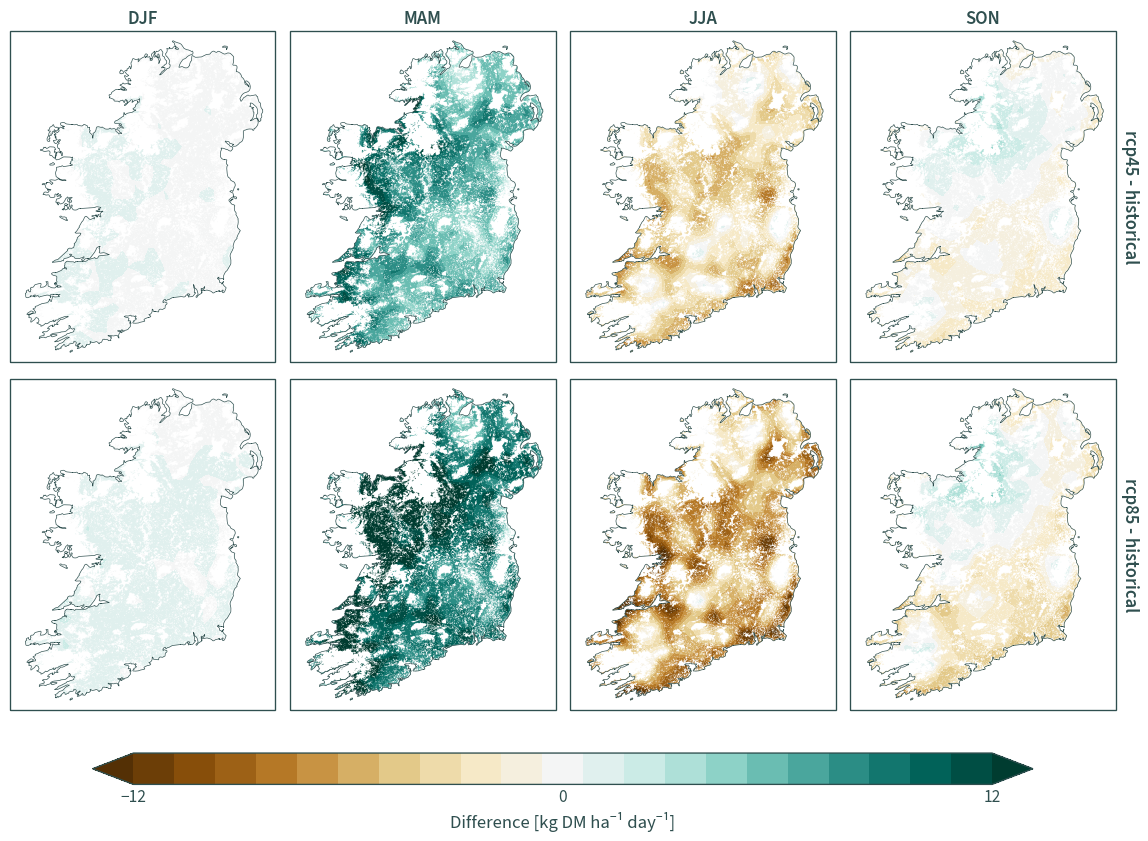

In [12]:
plot_diff(eurocordex_diff, "gro", 12)

In [13]:
eurocordex = generate_stats("EURO-CORDEX", "mean", "prod")
eurocordex_diff = calculate_diff(eurocordex)

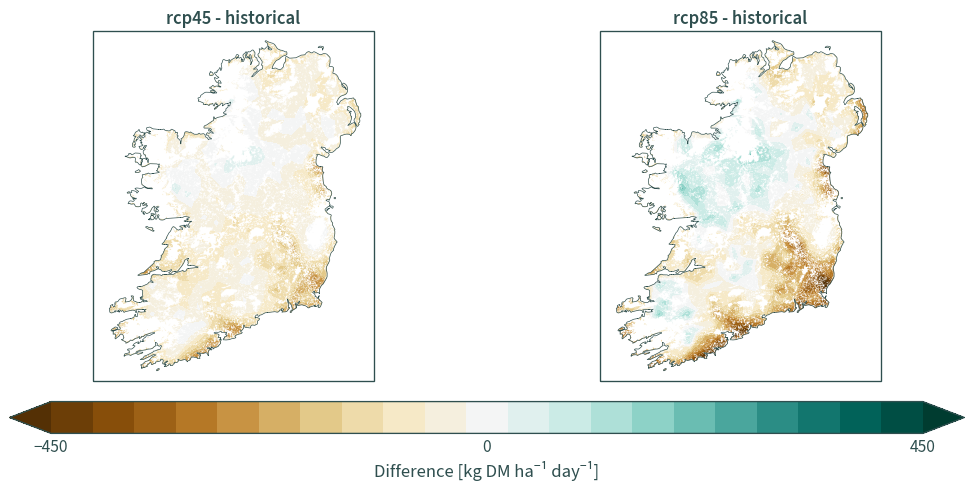

In [14]:
plot_diff(eurocordex_diff, "prod", 450)

#### HiResIreland

In [15]:
hiresireland = generate_stats("HiResIreland", "mean", "gro")
hiresireland_diff = calculate_diff(hiresireland)

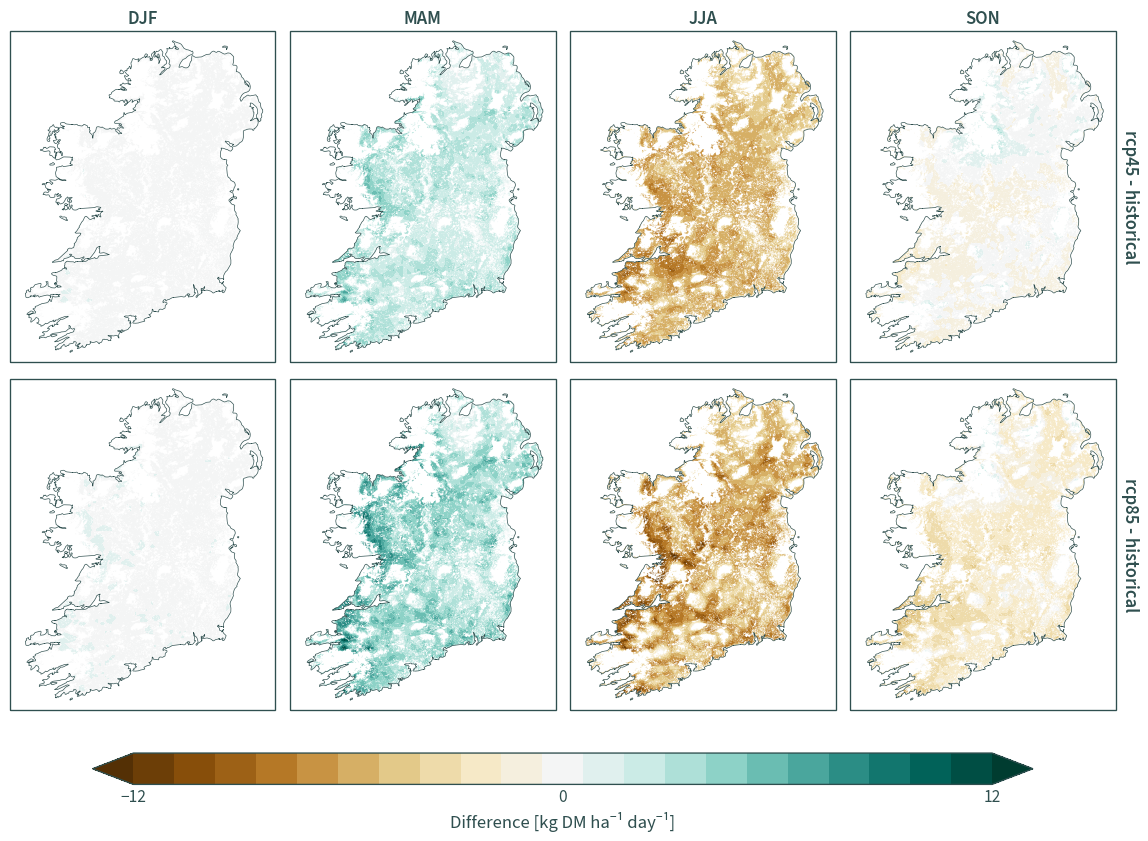

In [16]:
plot_diff(hiresireland_diff, "gro", 12)

In [17]:
hiresireland = generate_stats("HiResIreland", "mean", "prod")
hiresireland_diff = calculate_diff(hiresireland)

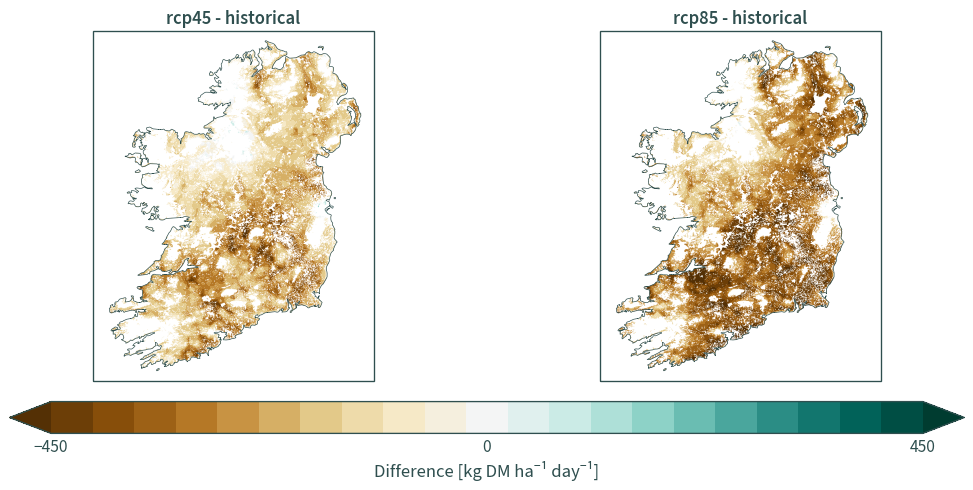

In [18]:
plot_diff(hiresireland_diff, "prod", 450)